## Imports

In [22]:
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import utils
from astropy.io import fits

## Read in Spectrum

In [91]:
DataDir = '/Users/Nathan/Documents/Berkeley/Chemical Evolution/DEIMOS/'
ObsRun = 'U112'
Mask = 'm15msk'
#Obj = '004.0000029'
#v = -50
Obj = '006.0000031'
#v = 70
#Obj = '007.0000034'
#v = 20
#Obj = '010.0010510'
#v = 90
File = DataDir+ObsRun+'/'+Mask+'/spec1d.'+Mask+'.'+Obj+'.fits'

#Method = 'Bxspf'
Method = 'Horne'

ObjHDUL = fits.open(File)

#aLambdaB = ObjHDUL[Method+'-B'].data['LAMBDA'][0]
#aLambdaR = ObjHDUL[Method+'-R'].data['LAMBDA'][0]
#
#aSpecB = ObjHDUL[Method+'-B'].data['SPEC'][0]
#aSpecR = ObjHDUL[Method+'-R'].data['SPEC'][0]
#
#aIvarB = ObjHDUL[Method+'-B'].data['IVAR'][0]
#aIvarR = ObjHDUL[Method+'-R'].data['IVAR'][0]

bLambdaB = ObjHDUL[Method+'-B'].data['LAMBDA'][0]
bLambdaR = ObjHDUL[Method+'-R'].data['LAMBDA'][0]

bSpecB = ObjHDUL[Method+'-B'].data['SPEC'][0]
bSpecR = ObjHDUL[Method+'-R'].data['SPEC'][0]

bIvarB = ObjHDUL[Method+'-B'].data['IVAR'][0]
bIvarR = ObjHDUL[Method+'-R'].data['IVAR'][0]

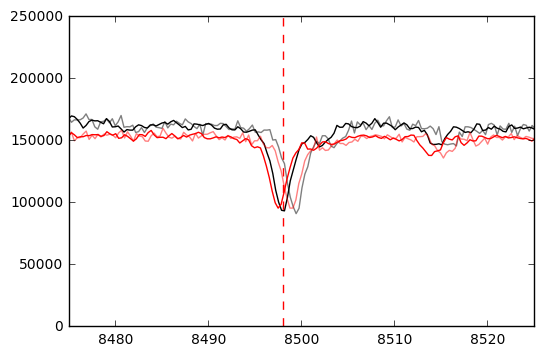

In [92]:
plt.plot(aLambdaR,aSpecR,c='k',alpha=0.5)
plt.plot(aLambdaR,utils.doppler_shift(aLambdaR,aSpecR,-50),c='k')

plt.plot(bLambdaR,bSpecR,c='r',alpha=0.5)
plt.plot(bLambdaR,utils.doppler_shift(bLambdaR,bSpecR,-50),c='r')

plt.axvline(x=8498,c='r',ls='--')
plt.axvline(x=8542,c='r',ls='--')
plt.axvline(x=8662,c='r',ls='--')

#plt.xlim(8475,8675)
plt.xlim(8475,8525)
#plt.xlim(8525,8550)
#plt.xlim(8650,8700)
plt.show()

In [107]:
path = '/Users/Nathan/Downloads/apogee_wavelength.npz'
tmp = np.load(path)
wavelength = tmp['wavelength']
tmp.close()

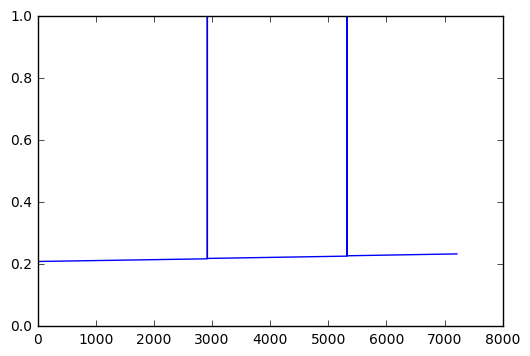

In [113]:
plt.plot(np.diff(wavelength))
plt.ylim(0,1)
plt.show()

In [98]:
np.diff(aLambdaR)

array([ 0.32373047,  0.32373047,  0.32373047, ...,  0.30371094,
        0.30371094,  0.30371094], dtype=float32)

## Wavelength Template

In [115]:
lambda_min = 6250 # AA
lambda_max = 9500 # AA
wavelength_template = np.arange(lambda_min,lambda_max,0.3)

np.savez('deimos_wavelength.npz',wavelength=wavelength_template)

In [105]:
wavelength_template

array([ 6250. ,  6250.3,  6250.6, ...,  9499.3,  9499.6,  9499.9])